In [2]:
%load_ext autoreload
%autoreload 2
import xarray as xr
import os
import numpy as np
from IPython.display import clear_output
from src.configs import *
from src.plotting import *
from src.pcs import *
from src.regions import *

# Compute and save gridded CRH

In [3]:
crh_file = data_dir('era5.merged.daily_crh.nc')
if os.path.isfile(crh_file):
    pass
else:
    q_ds = xr.open_dataset(data_dir('era5.merged.daily_q.nc')).Q.sel(level=np.linspace(100, 1000, 10))
    r_ds = xr.open_dataset(data_dir('era5.merged.daily_r.nc')).R.sel(level=np.linspace(100, 1000, 10))
    qs = q_ds.copy(data=q_ds.data/r_ds.data).rename('sat_specific_humidity')
    crh = q_ds.integrate('level')/qs.integrate('level')
    crh.to_netcdf()

# Compute local mean CRH around PFs

In [14]:
region = afc_region()
radius_in_degs = 2

In [15]:
# load PFs, look only in tropical region
pf_df = load_pf_stats(region.name)
pf_df = pf_df.where(pf_df.mean_latitude.abs() < 10).dropna()
pc_df = load_pf_stats(region.name)
pf_lat = pf_df.mean_latitude.values
pf_lon = pf_df.mean_longitude.values
pf_time = pd.to_datetime(pf_df.observation_time, format='%Y%m%d_%H:%M:%S')
pf_day = pf_time.dt.floor('D').values
# load CRH
crh = xr.open_dataarray(data_dir('era5.merged.daily_crh.nc'))
crh['time'] = crh['time'].dt.floor('D')
crh['lon'] = crh.lon - 180

In [16]:
def lat_lon_grid_slice(lat0, lon0, time0, radius_in_degs=5):
    slice_dict = {
        'lat': slice(lat0-radius_in_degs/2, lat0+radius_in_degs/2),
        'lon': slice(lon0-radius_in_degs/2, lon0+radius_in_degs/2),
        'time': time0
    }
    return slice_dict
grid_slices = [lat_lon_grid_slice(lat0, lon0, time0, radius_in_degs=5) for (lat0, lon0, time0) in zip(pf_lat, pf_lon, pf_day)]

In [17]:
crh_database_dict = {'crh': []}
for i, gs in enumerate(grid_slices):
    clear_output()
    print(f'PF {i+1} of {len(grid_slices)} ')
    obs_crh = crh.sel(gs)
    assert(obs_crh.lat.size>0 and obs_crh.lon.size>0)
    crh_database_dict['crh'].append(obs_crh.mean().item())
crh_database = pd.DataFrame.from_dict(crh_database_dict)
pf_df.join(crh_database).to_csv(data_dir(f'{region.name}.tropical_pf_crh_data_{radius_in_degs}deg.csv'))

PF 41584 of 41584 


In [3]:
ds = xr.open_dataset('/Users/pedro/era5/data/daily_mean.q.2015.nc')

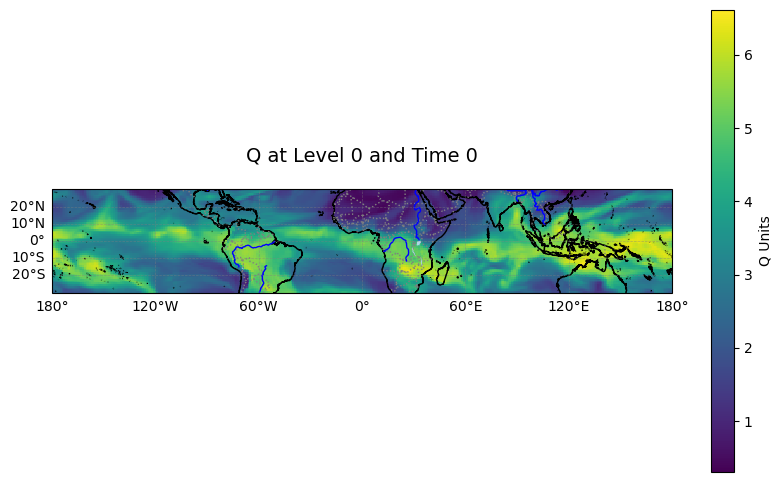

In [19]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

# Select the data slice you want to plot
data = ds.Q.integrate('level').isel(time=0)

# Define the map projection you want to use
# PlateCarree is a common choice for data in latitude and longitude
projection = ccrs.PlateCarree()

# Create a figure and a set of subplots with the specified projection
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': projection})

# Plot the data
# The 'transform' parameter specifies the coordinate system of the data
# Adjust 'transform' if your data uses a different coordinate system
data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis', cbar_kwargs={'label': 'Q Units'})

# Add geographical features
ax.coastlines(resolution='10m')  # High-resolution coastlines
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='gray')  # Country borders
ax.add_feature(cfeature.LAND, facecolor='lightgray')  # Land areas
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')  # Ocean areas
ax.add_feature(cfeature.LAKES, facecolor='lightblue')  # Lakes
ax.add_feature(cfeature.RIVERS, edgecolor='blue')  # Rivers

# Add gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

# Set extent if you want to focus on a specific region (optional)
# For example, to focus on North America:
# ax.set_extent([-170, -50, 10, 80], crs=ccrs.PlateCarree())

# Add a title
ax.set_title('Q at Level 0 and Time 0', fontsize=14, pad=20)

# Show the plot
plt.show()


In [18]:
data.pl

<xarray.DataArray 'Q' (time: 365, lat: 60, lon: 360)> Size: 63MB
array([[[3.81528714, 3.62135152, 3.41500931, ..., 4.24121031,
         4.14478982, 3.99780714],
        [3.18774237, 3.04413253, 2.90635057, ..., 3.67387151,
         3.51595622, 3.34210883],
        [2.67490448, 2.58477019, 2.52167202, ..., 3.0230874 ,
         2.91146812, 2.79124899],
        ...,
        [0.50315237, 0.53162247, 0.55430172, ..., 0.45458595,
         0.46063692, 0.47846349],
        [0.54538889, 0.57012701, 0.6047532 , ..., 0.47018503,
         0.49995251, 0.52641222],
        [0.58621695, 0.6076336 , 0.64958478, ..., 0.4809051 ,
         0.53371093, 0.5702556 ]],

       [[2.99662723, 3.07522937, 3.18644236, ..., 2.90067168,
         2.89934246, 2.93809574],
        [3.75918188, 3.78429724, 3.805944  , ..., 3.49001902,
         3.52661986, 3.67349651],
        [3.97580943, 3.95031997, 3.84531937, ..., 3.83889047,
         3.80672504, 3.90923184],
...
        [0.92224077, 0.92357324, 0.94612259, ..., 0.91825856,
         0.90119945, 0.91611555],
        [0.9948805 , 0.99864251, 0.99976382, ..., 1.09193801,
         1.02741224, 0.99456096],
        [1.13204033, 1.11329285, 1.09565926, ..., 1.24137959,
         1.20183576, 1.15618999]],

       [[2.05663776, 2.10253965, 2.12678491, ..., 2.27451476,
         2.00553672, 1.9400412 ],
        [2.09079497, 2.1247438 , 1.99324043, ..., 2.01274749,
         1.90039008, 2.03627034],
        [2.02746692, 2.0557779 , 1.89033987, ..., 1.86601347,
         1.97178597, 2.04461748],
        ...,
        [1.10557904, 1.0682786 , 1.03957475, ..., 1.1259626 ,
         1.11848244, 1.11992932],
        [1.22866856, 1.22391326, 1.20436618, ..., 1.19227969,
         1.21634428, 1.22642654],
        [1.24391802, 1.26148188, 1.27460623, ..., 1.12130476,
         1.16000888, 1.22486018]]])
Coordinates:
  * time     (time) datetime64[ns] 3kB 2015-01-01T11:00:00 ... 2015-12-31T11:...
  * lon      (lon) float64 3kB 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * lat      (lat) float64 480B -29.5 -28.5 -27.5 -26.5 ... 26.5 27.5 28.5 29.5